# Ejemplos de Punto Flotante: error en la estimación de derivadas

Se analiza a continuación el error cometido al tratar de estimar la derivada de una función alrededor de $x=x_0$. Sea $f:\mathbb{R}\to\mathbb{R}$ una función derivable en $x=x_0$, es decir, existe el límite:

$$ \lim_{h\to 0} \frac{f(x_0+h)-f(x_0)}{h}.$$

Se desea estimar la derivada de $f$ en $x=x_0$. De lo anterior, es bastante claro que debemos tomar $h\approx 0$ y hacer el cociente incremental. Si $h$ es suficientemente pequeño, matemáticamente obtendremos una aproximación razonable.

Sin embargo, al tratar de implementar esto en una máquina punto flotante, introducimos errores de redondeo que pueden alterar el resultado. La idea es que $f(x_0+h)$ es muy parecido a $f(x_0)$ por lo que su resta puede dar lugar a cancelaciones no deseadas, las cuales son amplificadas al dividir entre $h$ pequeño.

## Error de truncamiento (o error matemático)

El error de truncamiento de un algoritmo es el error cometido por realizar aproximaciones en la construcción del algoritmo. Es un error matemático, no debido a la representación numérica. En el caso anterior, el tomar $h>0$ (ya que con $h=0$ no podemos hacer el cociente) introduce un error. Podemos cuantificar el mismo usando el desarrollo de Taylor de $f$:

$$f(x_0+h) = f(x_0) + f'(x_0) h + \frac{1}{2}f''(\theta) h^2$$

donde $\theta \in [x_0,x_0+h]$ (resto de Lagrange). De lo anterior se deduce que:

$$\Delta f_{x_0} (h) := \frac{f(x_0+h) - f(x_0)}{h} = f'(x_0) + \frac{1}{2}f''(\theta) h.$$

$\Delta f_{x_0} (h)$ es nuestro cociente incremental, que vemos estima la derivada con un error que depende de $h$. Si $f''(\theta) \approx f''(x_0)$ (mientras $f''(x_0)$ no sea $0$ la aproximación funciona), obtenemos que:

$$E_{trunc} := |\Delta f_{x_0} (h)-f'(x_0)| \leqslant \frac{|f''(\theta)|}{2} h \approx \frac{|f''(x_0)|}{2} h $$

Por lo tanto, el *error de truncamiento* es lineal en $h$ en este caso.

**Nota:** El error de truncamiento debe su nombre precisamente a que hemos truncado el desarrollo de Taylor.

## Error de redondeo (o de punto flotante)

Recordemos que al almacenar un número en punto flotante, se comete un error, cuya magnitud relativa está dada por el $\epsilon_{mach}$. Es decir:

$$FP(x) = x(1+\delta) \quad |\delta|\leqslant \epsilon_{mach}.$$

Al hacer las operaciones anteriores, introducimos errores que se propagan. Consideremos para comenzar que solo introducimos error al hacer la resta, entonces:

$$FP(\Delta f_{x_0}(h)) = \frac{FP(f(x_0+h) - f(x_0))}{h} = \frac{(f(x_0+h) - f(x_0))(1+\delta)}{h} = \Delta f_{x_0}(h) + \frac{(f(x_0+h) - f(x_0))\delta}{h}.$$

Por lo tanto:
$$E_{red} (h) := |FP(\Delta f_{x_0}(h)) - \Delta f_{x_0}(h)| = \left|\frac{(f(x_0+h) - f(x_0))}{h}\right| |\delta|.$$

Sabemos que $|\delta|\leq \epsilon_{mach}$ por lo que:

$$E_{red} (h) \leq \left[|f(x_0+h)| + |f(x_0)|\right] \frac{\epsilon_{mach}}{h} \approx \frac{2 |f(x_0)| \epsilon_{mach}}{h}.$$

Es decir, este error *crece* cuando $h$ es más pequeño, negando la posibilidad de usar un $h \to 0$!!.

## Ejemplo

A modo de ejemplo, tomemos $f(x) = e^x$, cuya derivada en $x_0=0$ es $1$ (y su derivada segunda también).

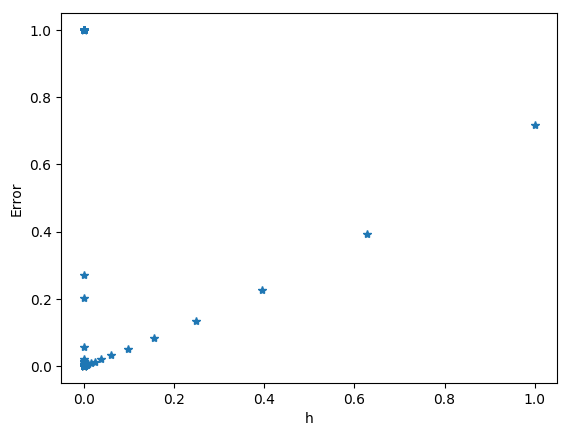

In [32]:
using PyPlot #paquete de gráficas

f(x) = exp.(x); # defino la función
x0=0.0;

h=logspace(-20,0,100); # defino un vector de h para evaluar, en escala logarítmica.

deltaf=(f(x0+h)-f(x0))./h; #./ quiere decir divido elemento a elemento.

E=abs.(deltaf - 1.0); # calculo el error cometido contra el valor que ya conozco.

plot(h,E,"*"); #grafico
xlabel("h");
ylabel("Error");

La gráfica anterior no permite discernir el comportamiento del error. Para ver magnitudes que están acercándose a $0$, es conveniente pasar a una **escala logarítmica**.

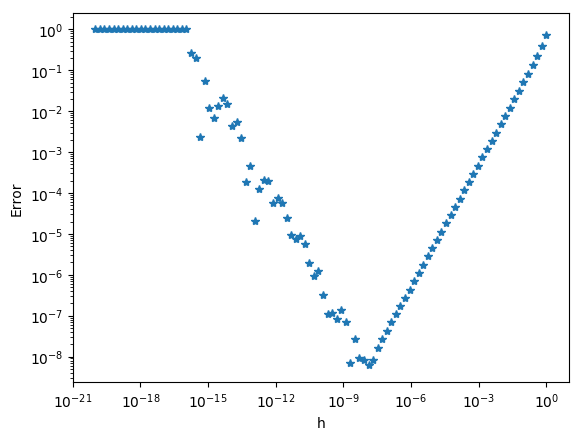

In [33]:
loglog(h,E,"*");
xlabel("h");
ylabel("Error");

En la gráfica anterior hay 3 zonas:

* Una donde domina el error de truncamiento (valores altos de h)
* Una donde domina el error de redondeo (valores de h hasta el $\epsilon_{mach}$).
* Una donde el error de representación ya produce una cancelación catastrófica $(h<\epsilon_{mach})$.

De las cotas del error obtenidas antes podemos estimar el error como:

$$E_{tot} = E_{trunc}+E_{red} \approx \frac{|f''(x_0)|}{2} h + \frac{2|f(x_0)|}{h}\epsilon_{mach}.$$


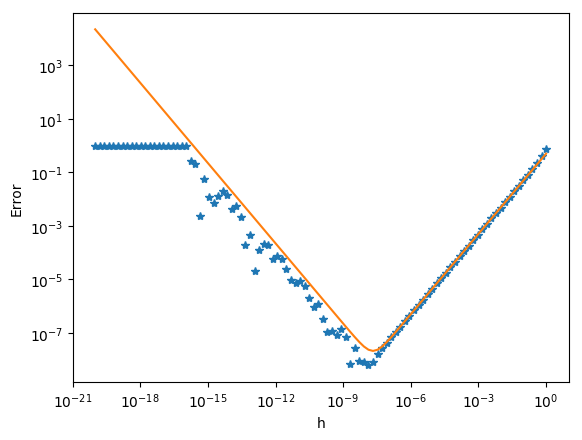

In [34]:
fx0 = abs(f(x0));
f2x0 = 1.0;  #o una estimación de f'' si no se dispone del valor.
epsilon_mach = eps()/2.0; #eps da el epsilon si truncamos. si redondeamos es la mitad.

cota_error(h) = f2x0/2.0 * h + 2*fx0*epsilon_mach./h;

loglog(h,E,"*");
loglog(h,cota_error(h));
xlabel("h");
ylabel("Error");


La cota anterior explica el comportamiento del error en las dos zonas de la derecha. 

**Pregunta: ¿Por qué el error queda constante en 10^0 = 1 cuando $h<\epsilon_{mach}$?**

Tiene sentido intentar minimizar el error anterior. Derivando respecto a $h$ y hallando el mínimo de la cota se tiene que:

$$h^* = \sqrt{\frac{4|f(x_0)| \epsilon_{mach}}{|f''(x_0)|}}.$$

Es decir, conviene usar un $h$ del orden $\sqrt{\epsilon_{mach}}$.

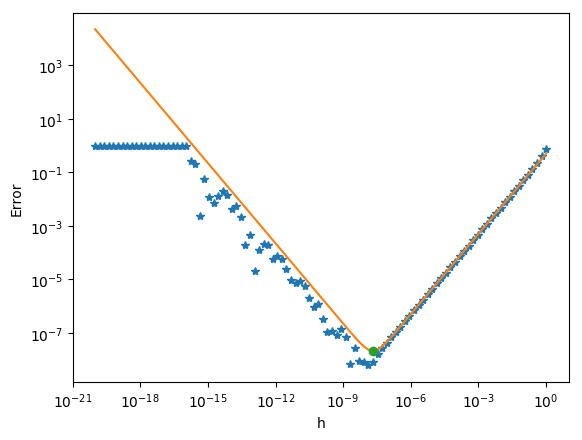

h^* = 2.1073424255447017e-8
epsilon_mach = 1.1102230246251565e-16


In [35]:
hoptimo = sqrt(4*fx0 * epsilon_mach/f2x0)
println("h^* = $hoptimo")
println("epsilon_mach = $(eps()/2)")
loglog(h,E,"*");
loglog(h,cota_error(h));
loglog(hoptimo,cota_error(hoptimo),"o")
xlabel("h");
ylabel("Error");


## Ejercicios

1. El valor de $h$ se puede elegir para que sea exacto en punto flotante. Pruebe utilizar $h = 1/2^i$ con i adecuado. Grafique nuevamente para ver si mejora el error de redondeo.

2. Analizar el caso de $f(x) = \sin(x)$ en $x_0=0$. ¿Por qué cambia el comportamiento?

3. Repetir el análisis para el cociente incremental
$$\tilde{\Delta} f_{x_0} (h) := \frac{f(x_0+h)-f(x_0-h)}{2h}.$$
para la función $f(x) = e^x$. En particular, hallar el nuevo $h^*$.

